In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

df = pd.read_excel("google reviews cleaned df_text.xlsx")
print(df.columns)

Index(['Stars', 'Reservation recommended', 'Visited on', 'Wait time',
       'Published date', 'isLocalGuide', 'Original language', 'Cleaned Text'],
      dtype='object')


[nltk_data] Downloading package wordnet to C:\Users\Zi
[nltk_data]     Hao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We begin pre-processing the google reviews with text for sentimental analysis.

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Lowercase, remove special characters, and extra spaces."""
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only alphanumeric characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords + Lemmatization
    return ' '.join(words)

df['Preprocessed Text'] = df['Cleaned Text'].apply(clean_text)

Let's preview the dataset.

In [6]:
print(df.head())

   Stars Reservation recommended Visited on     Wait time Published date  \
0      5                     Yes    Weekday  Up to 10 min     2025-02-27   
1      5                     NaN    Weekday           NaN     2025-02-27   
2      5                     NaN    Weekday           NaN     2025-02-27   
3      5                      No    Weekday     10–30 min     2025-02-27   
4      5                     NaN    Weekday           NaN     2025-02-27   

   isLocalGuide Original language  \
0         False                en   
1          True                id   
2          True                id   
3          True                en   
4          True                th   

                                        Cleaned Text  \
0  We had such a great day at Universal Studios S...   
1  Universal Studios Singapore is a very popular ...   
2                very amazing.\nmodern and beautiful   
3  This is one of the go to theme parks not only ...   
4  It's a bit old but still fun\n\nRecom

Let's segment the reviews into 5 segments based on 'Stars'.

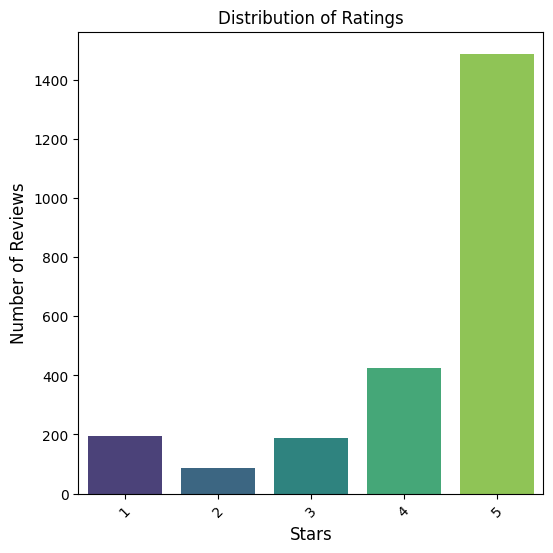

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each rating
rating_counts = df['Stars'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(6, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# Adding labels and title
plt.title('Distribution of Ratings', fontsize=12)
plt.xlabel('Stars', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()

Let's conduct sentimental analysis to better understand the tone behind the text data.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']  # The compound score indicates overall sentiment

df['Sentiment'] = df['Preprocessed Text'].apply(get_sentiment)
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
df['Sentiment_Label'].value_counts()


[nltk_data] Downloading package vader_lexicon to C:\Users\Zi
[nltk_data]     Hao\AppData\Roaming\nltk_data...


positive    1887
neutral      275
negative     218
Name: Sentiment_Label, dtype: int64

We follow up by plotting the sentiment label against the stars of the review.

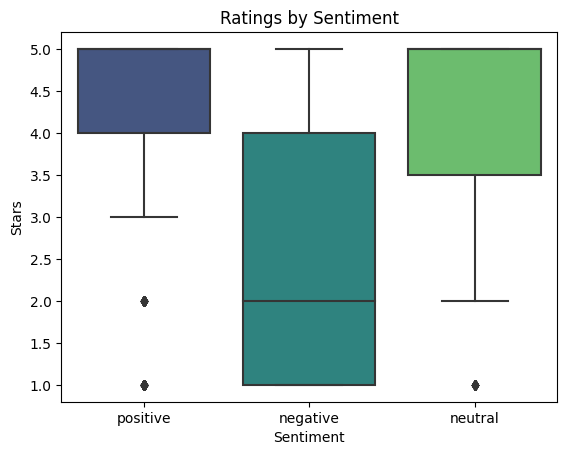

In [10]:
sns.boxplot(x='Sentiment_Label', y='Stars', data=df, palette='viridis')
plt.title('Ratings by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Stars')
plt.show()

We now look for the probable occurances of high-risk interactions stated in the reviews. We include high risk keywords and create a function to assign a risk score to these reviews.

In [ ]:
# Define high-risk keywords
high_risk_keywords = [
    "accident", "injury", "unsafe", "dangerous", "broken", "malfunction", 
    "sick", "food poisoning", "crowded", "long wait", "unhygienic", "fell", "hurt"
]